In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
pip install opendatasets --upgrade

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [ ]:
BASE_DIR = '/content/animefacedataset/images'
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

len(image_paths)

63565

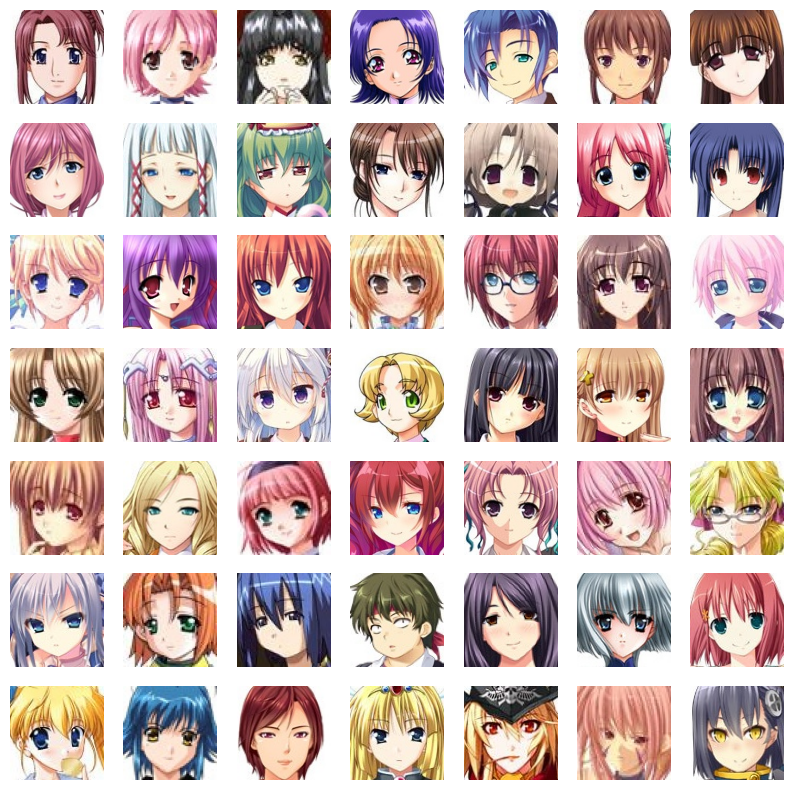

In [ ]:
# to display grid of images (7x7)
plt.figure(figsize=(10, 10))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)

    # load the image
    img = load_img(image_path)

    # convert to numpy array
    img = np.array(img)

    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

In [ ]:
image_size = (64, 64)

train_images = [
    np.array(load_img(path, target_size=image_size, color_mode='rgb'))
    for path in tqdm(image_paths)
]

# Convert to NumPy array
train_images = np.array(train_images)

# Optionally normalize to [-1, 1] for GAN training
train_images = (train_images.astype('float32') - 127.5) / 127.5

  0%|          | 0/63565 [00:00<?, ?it/s]

In [ ]:
train_images[0]

array([[[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  0.9843137 ,  0.99215686],
        [ 0.9764706 ,  0.99215686,  0.96862745],
        ...,
        [ 1.        ,  0.9372549 ,  0.9607843 ],
        [-0.6       , -0.7176471 , -0.6784314 ],
        [ 1.        ,  0.9529412 ,  0.9843137 ]],

       [[ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  0.9843137 ,  0.99215686],
        [ 0.99215686,  0.99215686,  0.9764706 ],
        ...,
        [ 1.        ,  0.9372549 ,  0.9529412 ],
        [ 0.7254902 ,  0.654902  ,  0.6784314 ],
        [ 0.24705882,  0.2       ,  0.21568628]],

       [[ 0.99215686,  1.        ,  1.        ],
        [ 1.        ,  0.99215686,  1.        ],
        [ 1.        ,  0.99215686,  1.        ],
        ...,
        [ 0.9607843 ,  0.88235295,  0.8901961 ],
        [ 0.92156863,  0.90588236,  0.9137255 ],
        [-0.20784314, -0.20784314, -0.20784314]],

       ...,

       [[ 1.        ,  0.9843137 ,  0.99215686],
        [ 0

In [ ]:
# latent dimension for random noise
LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

In [ ]:
generator = Sequential(name='generator')

# Dense + reshape
generator.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM, kernel_initializer=WEIGHT_INIT))
generator.add(layers.Reshape((8, 8, 512)))

# Upsample to 16x16
generator.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.2))

# Upsample to 32x32
generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.2))

# Upsample to 64x64
generator.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(0.2))

# Output layer
generator.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,066,051 (23.14 MB)

 Trainable params: 6,065,155 (23.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
discriminator = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# 64x64 → 32x32
discriminator.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
discriminator.add(layers.LeakyReLU(alpha=alpha))

# 32x32 → 16x16
discriminator.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

# 16x16 → 8x8
discriminator.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

# 8x8 → 4x4
discriminator.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(alpha=alpha))

# Output
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))

discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim, label_smoothing=True):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.label_smoothing = label_smoothing

        # Metrics to track losses
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # --------- Train Discriminator ---------
        with tf.GradientTape() as tape:
            # Real predictions
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones_like(pred_real)
            if self.label_smoothing:
                real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Fake predictions
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros_like(pred_fake)
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            d_loss = (d_loss_real + d_loss_fake) / 2

        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # --------- Train Generator ---------
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            target_labels = tf.ones_like(pred_fake)
            g_loss = self.loss_fn(target_labels, pred_fake)

        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}


In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=LATENT_DIM, save_dir='generated_samples'):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        tf.random.set_seed(42)  # consistent noise
        self.noise = tf.random.normal([num_imgs, latent_dim])
        self.g_losses = []
        self.d_losses = []

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            self.g_losses.append(logs.get('g_loss', 0.0))
            self.d_losses.append(logs.get('d_loss', 0.0))

        generated_images = self.model.generator(self.noise, training=False)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images = tf.clip_by_value(generated_images, 0, 255)
        generated_images = tf.cast(generated_images, tf.uint8).numpy()

        with plt.ioff():
            fig = plt.figure(figsize=(6, 6))
            for i in range(self.num_imgs):
                plt.subplot(5, 5, i + 1)
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                plt.imshow(img)
                plt.axis('off')
            plt.tight_layout()
            filename = os.path.join(self.save_dir, f'epoch_{epoch+1:03d}.png')
            plt.savefig(filename)
            plt.close(fig)

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')
        np.save(os.path.join(self.save_dir, 'g_losses.npy'), self.g_losses)
        np.save(os.path.join(self.save_dir, 'd_losses.npy'), self.d_losses)


In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001
G_LR = 0.0003

dcgan.compile(
    g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5),
    d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5),
    loss_fn=BinaryCrossentropy()
)


In [ ]:
N_EPOCHS = 15
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

Epoch 1/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 174s 77ms/step - d_loss: 0.6120 - g_loss: 1.8274
Epoch 2/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 178s 72ms/step - d_loss: 0.6068 - g_loss: 1.2439
Epoch 3/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 202s 72ms/step - d_loss: 0.5593 - g_loss: 1.3208
Epoch 4/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 202s 72ms/step - d_loss: 0.4962 - g_loss: 1.4980
Epoch 5/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 202s 72ms/step - d_loss: 0.4463 - g_loss: 1.6939
Epoch 6/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - d_loss: 0.3907 - g_loss: 1.9241
Epoch 7/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 203s 73ms/step - d_loss: 0.3387 - g_loss: 2.1697
Epoch 8/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 202s 73ms/step - d_loss: 0.3046 - g_loss: 2.4086
Epoch 9/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 201s 72ms/step - d_loss: 0.2787 - g_loss: 2.5851
Epoch 10/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 143s 72ms/step - d_loss: 0.2430 - g_loss: 2.8445
Epoch 11/15
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 202s 72ms/step - d_loss: 0.2138 - g_loss: 3.10

In [ ]:
import cv2
import os

sample_dir = 'generated_samples'  # folder where DCGANMonitor saved images
vid_fname = 'gans_training.mp4'   # output video file

# Collect and sort PNG files by epoch
files = sorted([
    os.path.join(sample_dir, f)
    for f in os.listdir(sample_dir)
    if f.endswith('.png')
])

# Read first image to get dimensions
sample_img = cv2.imread(files[0])
height, width, _ = sample_img.shape

# Create video writer object
out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

# Write each image frame to video
for fname in files:
    frame = cv2.imread(fname)
    out.write(frame)

out.release()
print(f"✅ Training video saved as: {vid_fname}")


✅ Training video saved as: gans_training.mp4


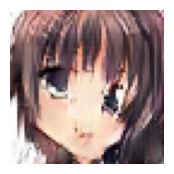

In [ ]:
noise = tf.random.normal([1, LATENT_DIM])            # 1 noise vector of 100 dims
g_img = dcgan.generator(noise)                # generate image
g_img = (g_img * 127.5) + 127.5               # denormalize from [-1, 1] → [0, 255]
g_img = g_img.numpy()                         # convert to NumPy
img = array_to_img(g_img[0])                  # format for plotting
fig = plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

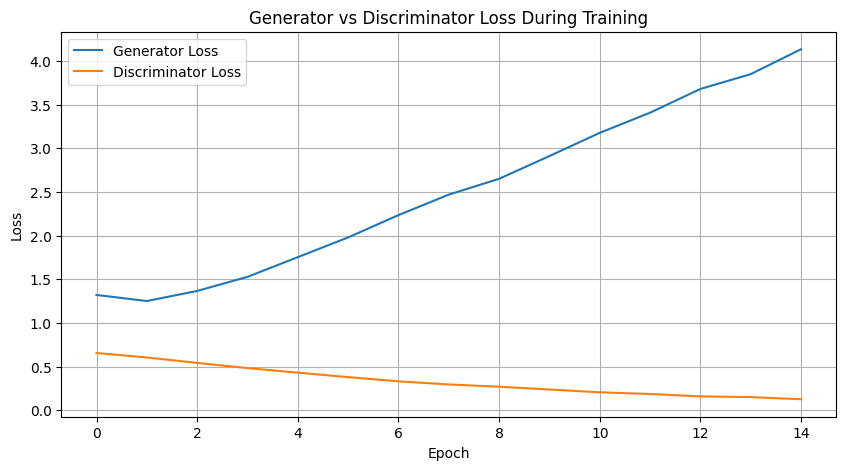